In [1]:
# import libraries and set plotting style
import numpy as np
import pandas as pd
import scipy as sp
import paramiko
from scipy import linalg,sparse,integrate
from scipy.special import factorial
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
# set ipython display and matplotlib notebook
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.container { width:90% !important; }</style>"))

# pdf and png output
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

# %matplotlib inline
%matplotlib notebook
#%matplotlib inline

# matplotlib style
plt.style.use('seaborn-notebook')

In [3]:
def get_D_Coeffs(s,d=2):
    '''
    Solve arbitrary stencil points s of length N with order of derivatives d<N
    can be obtained from equation on MIT website
    http://web.media.mit.edu/~crtaylor/calculator.html
    where the accuracy is determined as the usual form O(h^(N-d))
    
    Inputs:
        s: array like input of stencil points e.g. np.array([-3,-2,-1,0,1])
        d: order of desired derivative
    '''
    # let's solve an Ax=b problem
    N=s.size # stencil length
    A=[]
    for i in range(N):
        A.append(s**i)
    b=np.zeros(N)
    b[d] = factorial(d)
    x = np.linalg.solve(np.matrix(A),b)
    return x
def set_D(y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    '''
    Input:
        y: array of y values of channel
        order: order of accuracy desired (assuming even e.g. 2,4,6,...)
        d: dth derivative
    Output:
        D: (n-2 by n) dth derivative of order O(h^order) assuming uniform y spacing
    '''
    h = y[1]-y[0] # uniform spacing
    if not uniform:
        xi=np.linspace(0,1,y.size)
        h=xi[1] - xi[0]
    n = y.size
    ones=np.ones(n)
    I = np.eye(n)
    # get coefficients for main diagonals
    N=order+d # how many pts needed for order of accuracy
    if N>n:
        raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
    Nm1=N-1 # how many pts needed if using central difference is equal to N-1
    if (d % 2 != 0): # if odd derivative
        Nm1+=1 # add one more point to central, to count the i=0 0 coefficient
    # stencil and get Coeffs for diagonals
    s = np.arange(Nm1)-int((Nm1-1)/2) # stencil for central diff of order
    smax=s[-1] # right most stencil used (positive range)
    Coeffs = get_D_Coeffs(s,d=d)
    # loop over s and add coefficient matrices to D
    D = np.zeros_like(I)
    si = np.nditer(s,('c_index',))
    while not si.finished:
        i = si.index
        if si[0]==0:
            diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
        else:
            diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])

        D += diag_to_add
        if periodic:
            if si[0]>0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]-n)
            elif si[0]<0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]+n)
            if si[0]!=0:
                D += diag_to_add
                
        si.iternext()
    if not periodic:
        # alter BC so we don't go out of range on bottom of channel
        for i in range(0,smax):
            # for ith row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = np.arange(Nm1-1)-i # stencil for shifted diff of order-1
                else:
                    s = np.arange(Nm1)-i # stencil for shifted diff of order-1
            else:
                s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[i,:] = 0. # set row to zero
            D[i,s+i] = Coeffs # set row to have proper coefficients

            # for -ith-1 row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = -(np.arange(Nm1-1)-i) # stencil for shifted diff of order-1
                else:
                    s = -(np.arange(Nm1)-i) # stencil for shifted diff of order-1
            else:
                s = -(np.arange(N)-i) # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[-i-1,:] = 0. # set row to zero
            D[-i-1,s-i-1] = Coeffs # set row to have proper coefficients

    if output_full:
        D = (1./(h**d)) * D # do return the full matrix
    else:
        D = (1./(h**d)) * D[1:-1,:] # do not return the top or bottom row
    if not uniform:
        D = map_D(D,y,order=order,d=d,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=uniform)
    return D 
def map_D(D,y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    if not uniform:
        xi=np.linspace(0,1,y.size)
        if d==1: # if 1st derivative operator d(.)/dy = d(.)/dxi * dxi/dy
            dydxi = D@y # matrix multiply in python3
            dxidy = 1./dydxi # element wise invert
            return D*dxidy[:,np.newaxis] # d(.)/dy = d(.)/dxi * dxi/dy
        elif d==2: # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
            D1=set_D(xi,order=order,d=1,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=True)
            dydxi = D1@y
            dxidy = 1./dydxi # element wise invert
            #d2ydxi2 = D@y # d^2y/dxi^2
            #d2xidy2 = 1./d2ydxi2 # d^2xi/dy^2 = 1./(d^2y/dxi^2)
            d2xidy2 = -(D@y)*(dxidy)**3
            #print('d2xidy2 = ',d2xidy2)
            return (D*(dxidy[:,np.newaxis]**2)) + (D1*d2xidy2[:,np.newaxis])  # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
        else:
            print('Cannot do this order of derivative with non-uniform mesh.  your input order of derivative = ',d)
    else:
        return D

In [4]:
def read_file(fname):
    with open(fname, 'rb') as fid:
        time=np.fromfile(fid,dtype='>d',count=1)
        nu = np.fromfile(fid,dtype='>d',count=1)

        n = np.fromfile(fid,dtype='>i',count=1)
        x = np.fromfile(fid,dtype='>d',count=n[0])

        n = np.fromfile(fid,dtype='>i',count=1)
        y = np.fromfile(fid,dtype='>d',count=n[0])

        n = np.fromfile(fid,dtype='>i',count=1)
        z = np.fromfile(fid,dtype='>d',count=n[0])

        n = np.fromfile(fid,dtype='>i',count=1)
        xm = np.fromfile(fid,dtype='>d',count=n[0])

        n = np.fromfile(fid,dtype='>i',count=1)
        ym = np.fromfile(fid,dtype='>d',count=n[0])

        n = np.fromfile(fid,dtype='>i',count=1)
        zm = np.fromfile(fid,dtype='>d',count=n[0])

        n = np.fromfile(fid,dtype='>i',count=3)
        U = np.fromfile(fid,dtype='>d',count=n[0]*n[1]*n[2])
        U = U.reshape((n[0],n[1],n[2]),order='F')

        n = np.fromfile(fid,dtype='>i',count=3)
        V = np.fromfile(fid,dtype='>d',count=n[0]*n[1]*n[2])
        V = V.reshape((n[0],n[1],n[2]),order='F')

        n = np.fromfile(fid,dtype='>i',count=3)
        W = np.fromfile(fid,dtype='>d',count=n[0]*n[1]*n[2])
        W = W.reshape((n[0],n[1],n[2]),order='F')
        
    return time,x,y,z,xm,ym,zm,U,V,W
def create_grid_and_remove_ghostpoints(x,y,z,xm,ym,zm,U,V,W):
    ''' removes the ghost points from U(t,x,y,z) and V and W and generates respective grids for each of the velocity componenets 
    Parameters:
        x,y,z - grid corners
        xm,ym,zm - grid centers (not including ghost points)
        U,V,W - velocities with indices in order of time,x,y,z on staggered grid.  Velocity through cell faces and normal direction
    
    '''
    # remove ghost points
    Xu,Yu,Zu=np.meshgrid(x,ym,zm,indexing='ij')
    Xv,Yv,Zv=np.meshgrid(xm,y,zm,indexing='ij')
    Xw,Yw,Zw=np.meshgrid(xm,ym,z,indexing='ij')
    U=U[:,:,1:-1,1:-1]
    V=V[:,1:-1,:,1:-1]
    W=W[:,1:-1,1:-1,:]
    return Xu,Yu,Zu,U,Xv,Yv,Zv,V,Xw,Yw,Zw,W
    
    
fnames=!ls bl*
fname=fnames[0]
print(fnames)
U,V,W=[],[],[]
time=[]
for fnamei in fnames[::10]:
    %time timei,x,y,z,xm,ym,zm,Ui,Vi,Wi = read_file(fnamei)
    time.append(timei)
    U.append(Ui)
    V.append(Vi)
    W.append(Wi)
time=np.array(time).flatten()
U=np.array(U)
V=np.array(V)
W=np.array(W)
%time Xu,Yu,Zu,U,Xv,Yv,Zv,V,Xw,Yw,Zw,W=create_grid_and_remove_ghostpoints(x,y,z,xm,ym,zm,U,V,W)

['ls: cannot access bl*: No such file or directory']


FileNotFoundError: [Errno 2] No such file or directory: 'ls: cannot access bl*: No such file or directory'

NameError: name 'timei' is not defined

In [37]:
def read_file_sftp(rfile):
    time=np.frombuffer(rfile.read(size=8),dtype='>d',count=1)
    print(time)
    nu = np.frombuffer(rfile.read(size=8),dtype='>d',count=1)
    print(nu)

    n = np.frombuffer(rfile.read(size=4),dtype='>i',count=1)
    x = np.frombuffer(rfile.read(size=8*n[0]),dtype='>d',count=n[0])

    n = np.frombuffer(rfile.read(size=4),dtype='>i',count=1)
    y = np.frombuffer(rfile.read(size=8*n[0]),dtype='>d',count=n[0])

    n = np.frombuffer(rfile.read(size=4),dtype='>i',count=1)
    z = np.frombuffer(rfile.read(size=8*n[0]),dtype='>d',count=n[0])

    n = np.frombuffer(rfile.read(size=4),dtype='>i',count=1)
    xm = np.frombuffer(rfile.read(size=8*n[0]),dtype='>d',count=n[0])

    n = np.frombuffer(rfile.read(size=4),dtype='>i',count=1)
    ym = np.frombuffer(rfile.read(size=8*n[0]),dtype='>d',count=n[0])

    n = np.frombuffer(rfile.read(size=4),dtype='>i',count=1)
    zm = np.frombuffer(rfile.read(size=8*n[0]),dtype='>d',count=n[0])

    n = np.frombuffer(rfile.read(size=4*3),dtype='>i',count=3)
    U = np.frombuffer(rfile.read(size=8*n[0]*n[1]*n[2]),dtype='>d',count=n[0]*n[1]*n[2])
    U = U.reshape((n[0],n[1],n[2]),order='F')

    n = np.frombuffer(rfile.read(size=4*3),dtype='>i',count=3)
    V = np.frombuffer(rfile.read(size=8*n[0]*n[1]*n[2]),dtype='>d',count=n[0]*n[1]*n[2])
    V = V.reshape((n[0],n[1],n[2]),order='F')

    n = np.frombuffer(rfile.read(size=4*3),dtype='>i',count=3)
    W = np.frombuffer(rfile.read(size=8*n[0]*n[1]*n[2]),dtype='>d',count=n[0]*n[1]*n[2])
    W = W.reshape((n[0],n[1],n[2]),order='F')

    return time,x,y,z,xm,ym,zm,U,V,W
client = paramiko.SSHClient()
client.load_system_host_keys()
client.connect('certainty-login.stanford.edu')


sftp_client = client.open_sftp()
#remote_file = sftp_client.open('remote_filename.txt',mode='rb')
remote_file = sftp_client.open('bl_H-type_PSE_inflow_dt_period.85000',mode='rb')
#binary_data = remote_file.read()
%time timei,x,y,z,xm,ym,zm,Ui,Vi,Wi = read_file_sftp(remote_file)


#try:
    #for line in remote_file:
        #print(line)# process line
#finally:
    #remote_file.close()

[9.56086552]
[5.54754268e-06]
CPU times: user 21min 44s, sys: 27min 54s, total: 49min 38s
Wall time: 48min 49s


In [19]:
binary_data

NameError: name 'binary_data' is not defined

<IPython.core.display.Javascript object>


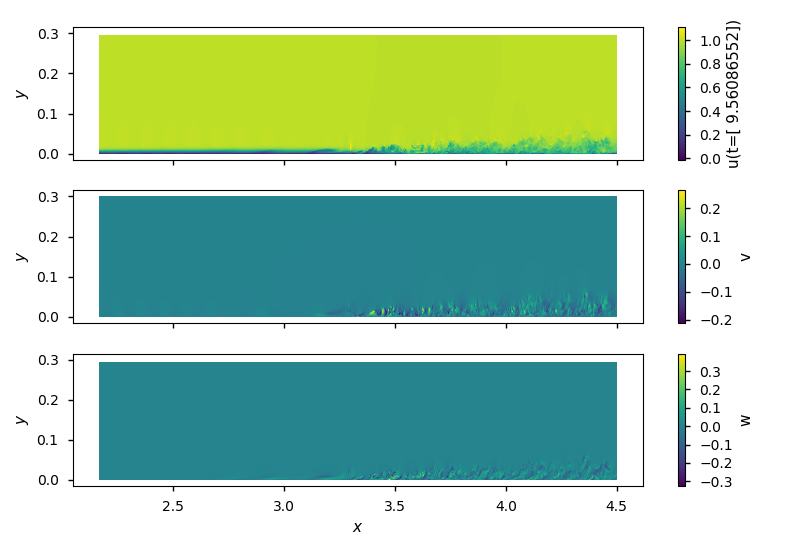

In [8]:
for timei in [0,]:
    fig,[axU,axV,axW]=plt.subplots(nrows=3,sharey=True,sharex=True)
    fig.colorbar(axU.pcolormesh(Xu[:,:,2],Yu[:,:,2],U[timei,:,:,2]),ax=axU,label='u(t={})'.format(time[timei]))
    fig.colorbar(axV.pcolormesh(Xv[:,:,2],Yv[:,:,2],V[timei,:,:,2]),ax=axV,label='v')
    fig.colorbar(axW.pcolormesh(Xw[:,:,2],Yw[:,:,2],W[timei,:,:,2]),ax=axW,label='w')
    axs=[axU,axV,axW]
    [ax.set_ylabel(r'$y$') for ax in axs]
    axW.set_xlabel(r'$x$')
    fig.tight_layout()

In [27]:
time

array([  9.56086552,   9.61710591,   9.61710591,   9.72958668,
         9.78582707,   9.84206745,   9.89830784,   9.89830784,
        10.01078861,  10.01078861,  10.12326938,  10.17950976])

In [ ]:
# average and fluctuating
Umean=np.mean(U,axis=(0,-1))
Vmean=np.mean(V,axis=(0,-1))
Wmean=np.mean(W,axis=(0,-1))

<IPython.core.display.Javascript object>


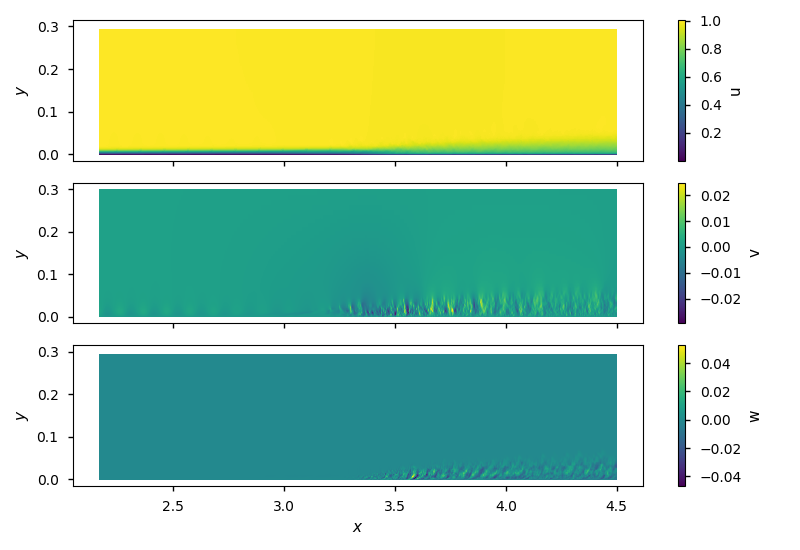

In [11]:
fig,[axU,axV,axW]=plt.subplots(nrows=3,sharey=True,sharex=True)
fig.colorbar(axU.pcolormesh(Xu[:,:,2],Yu[:,:,2],Umean[:,:]),ax=axU,label='u')
fig.colorbar(axV.pcolormesh(Xv[:,:,2],Yv[:,:,2],Vmean[:,:]),ax=axV,label='v')
fig.colorbar(axW.pcolormesh(Xw[:,:,2],Yw[:,:,2],Wmean[:,:]),ax=axW,label='w')
axs=[axU,axV,axW]
[ax.set_ylabel(r'$y$') for ax in axs]
axW.set_xlabel(r'$x$')
fig.tight_layout()

In [ ]:
Uprime=U-Umean[np.newaxis,:,:,np.newaxis]
Vprime=V-Vmean[np.newaxis,:,:,np.newaxis]
Wprime=W-Wmean[np.newaxis,:,:,np.newaxis]

<IPython.core.display.Javascript object>


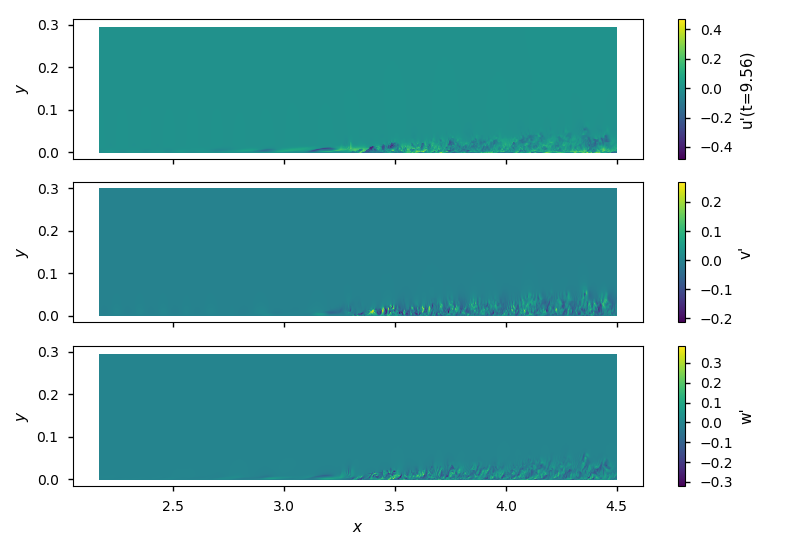

In [26]:
for timei in [0,]:
    fig,[axU,axV,axW]=plt.subplots(nrows=3,sharey=True,sharex=True)
    fig.colorbar(axU.pcolormesh(Xu[:,:,2],Yu[:,:,2],Uprime[timei,:,:,2]),ax=axU,label="u'(t={0:.2f})".format(time[timei]))
    fig.colorbar(axV.pcolormesh(Xv[:,:,2],Yv[:,:,2],Vprime[timei,:,:,2]),ax=axV,label="v'")
    fig.colorbar(axW.pcolormesh(Xw[:,:,2],Yw[:,:,2],Wprime[timei,:,:,2]),ax=axW,label="w'")
    axs=[axU,axV,axW]
    [ax.set_ylabel(r'$y$') for ax in axs]
    axW.set_xlabel(r'$x$')
    fig.tight_layout()

In [24]:
time=time.flatten()